In [17]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import pyodbc
from datetime import datetime
import seaborn as sns


In [ ]:
# Configuration for SQL Server connection
server = 'YOUR_SERVER_NAME\\SQLSERVER'
database = 'your_database_name' 

# Create the connection string for Windows Authentication
conn_str = (
    f"DRIVER={{ODBC Driver 17 for SQL Server}};"
    f"SERVER={server};"
    f"DATABASE={database};"
    f"Trusted_Connection=yes;"
)

# Connect to SQL Server
conn = pyodbc.connect(conn_str)

# Load datasets from SQL Server
customer_profile_query = "SELECT * FROM dim_customer"
products_query = "SELECT * FROM dim_product"
fact_query = "SELECT * FROM fact"

customers = pd.read_sql(customer_profile_query, conn)
fact = pd.read_sql(fact_query, conn)
products = pd.read_sql(products_query, conn)


C:\Users\21276\AppData\Local\Temp\ipykernel_43800\383875678.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  customers = pd.read_sql(customer_profile_query, conn)
C:\Users\21276\AppData\Local\Temp\ipykernel_43800\383875678.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  fact = pd.read_sql(fact_query, conn)
C:\Users\21276\AppData\Local\Temp\ipykernel_43800\383875678.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  products = pd.read_sql(products_query, conn)


# Étape 1 : Calculer l'âge des clients

In [9]:

# Étape 1 : Calculer l'âge des clients
customers['date_of_birth'] = pd.to_datetime(customers['date_of_birth'])
customers['age'] = datetime.now().year - customers['date_of_birth'].dt.year


# Étape 2 : Ajouter les prix des produits et calculer le montant total dépensé par client

In [10]:

purchases = fact.merge(products[['product_id', 'price_per_unit']], on='product_id', how='left')
purchases['total_spent'] = purchases['quantity'] * purchases['price_per_unit']


# Étape 3 : Agréger les données d'achat par client

In [11]:
# Étape 3 : Agréger les données d'achat par client
customer_purchases = purchases.groupby('customer_id').agg(
    total_quantity=('quantity', 'sum'),
    total_spent=('total_spent', 'sum')
).reset_index()

# Étape 4 : Fusionner avec les données des clients

In [12]:
data = pd.merge(customers[['customer_id', 'age']], customer_purchases, on='customer_id', how='inner')

# Étape 4 : Normaliser les données pour la segmentation

In [13]:
features = data[['age', 'total_quantity', 'total_spent']]
scaler = StandardScaler()
normalized_features = scaler.fit_transform(features)

# Étape 6 : Recherche du nombre optimal de clusters

c:\Users\21276\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\21276\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\21276\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\21276\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

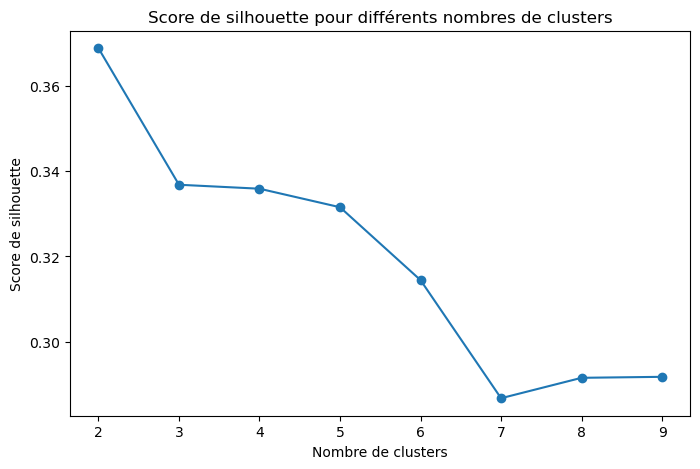

Nombre optimal de clusters : 2


In [14]:

# Étape 6 : Recherche du nombre optimal de clusters
silhouette_scores = []
range_clusters = range(2, 10)
for k in range_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(normalized_features)
    silhouette_scores.append(silhouette_score(normalized_features, kmeans.labels_))
# Afficher le score de silhouette pour chaque k
plt.figure(figsize=(8, 5))
plt.plot(range_clusters, silhouette_scores, marker='o')
plt.title('Score de silhouette pour différents nombres de clusters')
plt.xlabel('Nombre de clusters')
plt.ylabel('Score de silhouette')
plt.show()

# Sélection automatique du meilleur nombre de clusters
optimal_clusters = range_clusters[silhouette_scores.index(max(silhouette_scores))]
print(f"Nombre optimal de clusters : {optimal_clusters}")

# Étape 7 : Appliquer K-Means avec le nombre optimal de clusters

In [15]:
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
data['cluster'] = kmeans.fit_predict(normalized_features)

c:\Users\21276\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


# Étape 8 : Analyse des clusters

In [16]:
cluster_analysis = data.groupby('cluster').agg(
    avg_age=('age', 'mean'),
    avg_quantity=('total_quantity', 'mean'),
    avg_spent=('total_spent', 'mean'),
    count=('customer_id', 'count')
).reset_index()

print("\nAnalyse des clusters :")
print(cluster_analysis)



Analyse des clusters :
   cluster    avg_age  avg_quantity     avg_spent  count
0        0  45.640535     16.862333  11159.010363    523
1        1  45.016771     47.004193  38212.517191    477


# Étape 9 : Visualisation des clusters

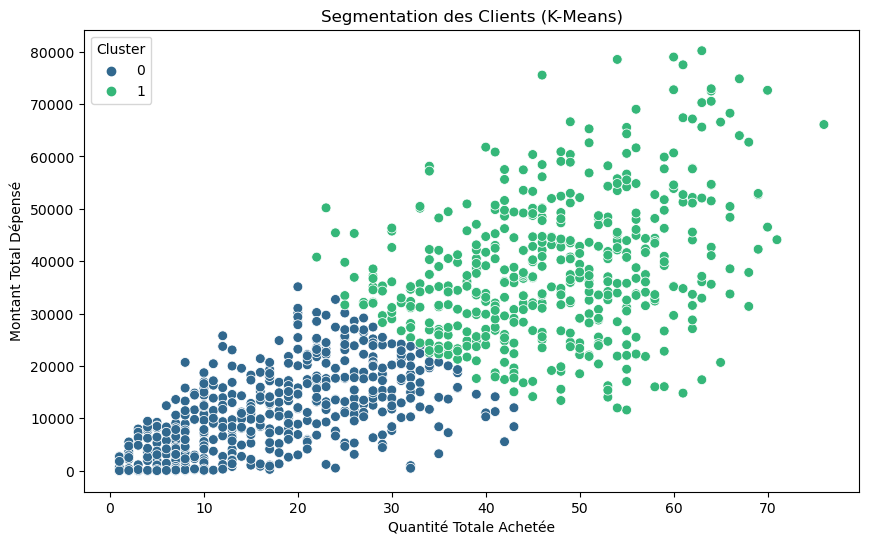

In [18]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=data['total_quantity'], 
    y=data['total_spent'], 
    hue=data['cluster'], 
    palette='viridis', 
    s=50
)
plt.title("Segmentation des Clients (K-Means)")
plt.xlabel("Quantité Totale Achetée")
plt.ylabel("Montant Total Dépensé")
plt.legend(title="Cluster", loc='upper left')
plt.show()